In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import glob
import PIL
import PIL.Image
import glob
import pathlib
import matplotlib.pyplot as plt

from tensorflow.keras import layers
import tensorflow_addons as tfa

c:\Users\Kostas\anaconda3\envs\vit\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
dataset_dir = r"C:\Users\Kostas\Desktop\GIMA\Module_7\Data\filtered_patches_GEE_3_bands"

In [3]:
# Importing the dataset

print('Training Data')

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=dataset_dir,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=100,
    validation_split=0.3,
    subset='training',
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

print('\nValidation Data')

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=dataset_dir,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=100,
    validation_split=0.3,
    subset='validation',
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Training Data
Found 1943 files belonging to 2 classes.
Using 1361 files for training.

Validation Data
Found 1943 files belonging to 2 classes.
Using 582 files for validation.


In [4]:
print(type(train_dataset))
class_names = train_dataset.class_names # return type: list
print(class_names)
type(class_names)

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
['11', '60']


list

## Convert BatchDataset to NumPy
tf.keras.preprocessing.image_dataset_from_directory results in a batch dataset, but the model needs it as a numpy array.

In [6]:
import tensorflow_datasets as tfds

c:\Users\Kostas\anaconda3\envs\vit\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
for images, labels in train_dataset:
    print(type(images.numpy()))
    print(type(labels.numpy()))
    print(type(np.array(images)))
    print(type(np.array(labels)))
    break


<class 'numpy.ndarray'>
<class 'numpy.int32'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [24]:
train_dataset = train_dataset.unbatch()
images = list(train_dataset.map(lambda x, y: x))
labels = list(train_dataset.map(lambda x, y: y))

In [37]:
y = np.concatenate([y for x, y in train_dataset], axis=0)

ValueError: zero-dimensional arrays cannot be concatenated

In [43]:
for images, labels in train_dataset.take(-1):  # only take first element of dataset
    print("images", images)
    print("LABELS", labels)
    numpy_labels = np.array(labels)
    break

images tf.Tensor(
[[[ 0.         0.         0.       ]
  [ 0.         0.         0.       ]
  [ 0.         0.         0.       ]
  ...
  [ 0.         0.         0.       ]
  [ 0.         0.         0.       ]
  [ 0.         0.         0.       ]]

 [[ 0.         0.         0.       ]
  [ 2.5407028  3.9804344  3.1335335]
  [ 7.144661  11.193302   8.8117485]
  ...
  [ 8.097282  11.669613  12.86039  ]
  [ 2.8794632  4.1498146  4.573265 ]
  [ 0.         0.         0.       ]]

 [[ 0.         0.         0.       ]
  [ 7.144661  11.193302   8.8117485]
  [20.091362  31.476467  24.779346 ]
  ...
  [22.77021   32.81589   36.16445  ]
  [ 8.097282  11.669613  12.86039  ]
  [ 0.         0.         0.       ]]

 ...

 [[ 0.         0.         0.       ]
  [17.861652  23.815536  30.483887 ]
  [50.228405  66.97121   85.723145 ]
  ...
  [16.07309   22.77021   22.100498 ]
  [ 5.7157288  8.097282   7.859127 ]
  [ 0.         0.         0.       ]]

 [[ 0.         0.         0.       ]
  [ 6.351757   8.46

In [41]:
print(numpy_labels[0])

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

UNTIL HERE TOMORROW

In [15]:
num_classes = len(class_names)
input_shape = (800, 800, 3)

# I should add the dataset here to read it
# I should also add a segment that resizes the input images to the desired XY dimensions

#(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

# print(f"Train data shapes \nx_train: {x_train.shape} \ty_train: {y_train.shape}")
# print(f"Test data shapes \nx_test: {x_test.shape} \ty_test: {y_test.shape}")

## Configuring hyperparameters

In [16]:
# learning rate will need a few tests. I am leaving the suggested one here
learning_rate = 0.001

# The same applies for weight decay
weight_decay = 0.0001

# The batch size will probably need some adjusting. I think that it should be less.
batch_size = 256
num_epochs = 100

# Resizing the input images. To be decided which size to use
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extracted from the input images

# This should stay as it is.
num_patches = (image_size // patch_size) ** 2

# The linear projection dimension. It is used in many steps along the process
projection_dim = 64

# The number of Attention Heads. I will start with 3 because the processing grows a lot by tweaking them.
num_heads = 3


transformer_units = [
    projection_dim * 2,
    projection_dim,
]  

# Size of the transformer layers
transformer_layers = 8

# Classifier (last step)
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

## Building the different components of the model

### Multilayer Perceptron (MLP)

In [17]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.relu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

### Patch creation

Creating a class for the patch creation which will be used in each input image

In [18]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1], # The stride controls the overlapping of patches
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Displaying a patch

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


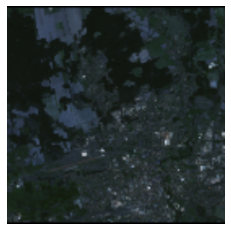

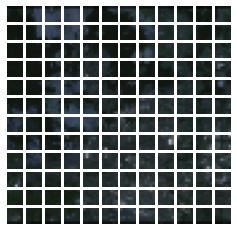

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

### Patch encoder

Does the following:
1. Project the patches with a linear projection
2. Adds a token
3. Adds positional embedding to the patches

In [20]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

## Building the ViT model

In [21]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    # augmented = data_augmentation(inputs) --> Didn't add data augmentation yet
    # Create patches.
    patches = Patches(patch_size)#(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):

        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [22]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

TypeError: Exception encountered when calling layer "patch_encoder" (type PatchEncoder).

Inputs to a layer should be tensors. Got: <__main__.Patches object at 0x000001B9E2F2D4E0>

Call arguments received by layer "patch_encoder" (type PatchEncoder):
  • patch=<__main__.Patches object at 0x000001B9E2F2D4E0>